# Support Vector Machine (SVM) pour Classification Binaire - Diagnostic du Cancer

Ce notebook implémente les modèles **L1-SVM** et **L2-SVM** pour le diagnostic du cancer (Bénin vs Malin).

## Équations du SVM

### L1-SVM (Primal Form):
$$\min_{w,b} \frac{1}{p}w^T w + C \sum_{i=1}^{p} \max(0, 1 - y_i'(w \cdot x_i + b))$$

### L2-SVM:
$$\min_{w,b} \frac{1}{p}||w||_2^2 + C \sum_{i=1}^{p} \max(0, 1 - y_i'(w \cdot x_i + b))^2$$

Où:
- $w$ : vecteur de poids
- $b$ : biais
- $C$ : paramètre de régularisation
- $y_i' \in \{-1, +1\}$ : labels

**Auteur**: maramchebbi  
**Date**: 2025-11-19

## 1. Installation et Importation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC, SVC
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
print("✅ Bibliothèques importées!!!! avec succès")

✅ Bibliothèques importées!!!! avec succès


## 2. Chargement des Données

In [9]:
data=pd.read_csv("C:/Users/USER/Desktop/Breast_Cancer_Detection_ML_Project/data/row/data.csv")
data

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [10]:
print("📊 Dimensions du dataset:",data.shape)
print("\n📋 Premières lignes:")
print(data.head())

print("\n📈 Distribution des diagnostics:")
print(data['diagnosis'].value_counts())
print("\n📊 Pourcentage:")
print(data['diagnosis'].value_counts(normalize=True) * 100)

📊 Dimensions du dataset: (569, 33)

📋 Premières lignes:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...

## 3. Préparation des Données

In [11]:
# Nettoyage et préparation
# 1. Supprimer les colonnes inutiles
if 'id' in data.columns:
    data = data.drop('id', axis=1)

# Supprimer les colonnes vides (Unnamed)
unnamed_cols = [col for col in data.columns if 'Unnamed' in col]
if unnamed_cols:
    print(f"⚠️ Suppression des colonnes vides: {unnamed_cols}")
    data = data.drop(columns=unnamed_cols)

# 2. Encoder le diagnostic (M=1, B=0)
le = LabelEncoder()
data['diagnosis'] = le.fit_transform(data['diagnosis'])
print(f"\n✅ Encodage: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# 3. Séparer features et cible
X = data.drop('diagnosis', axis=1).values
y = data['diagnosis'].values

# Convertir y en {-1, +1} pour le SVM
y_svm = np.where(y == 0, -1, 1)

print(f"\n📊 Dimensions:")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")
print(f"  Classes SVM: {np.unique(y_svm)}")

# 4. Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n✅ Données normalisées")
print(f"  Mean: {X_scaled.mean():.4f}")
print(f"  Std: {X_scaled.std():.4f}")

⚠️ Suppression des colonnes vides: ['Unnamed: 32']

✅ Encodage: {'B': np.int64(0), 'M': np.int64(1)}

📊 Dimensions:
  X: (569, 30)
  y: (569,)
  Classes SVM: [-1  1]

✅ Données normalisées
  Mean: -0.0000
  Std: 1.0000


In [12]:
# 5. Division train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_svm, test_size=0.2, random_state=42, stratify=y_svm
)

print(f"\n📊 Taille des ensembles:")
print(f"  Train: {X_train.shape[0]} samples ({np.sum(y_train==-1)} Bénin, {np.sum(y_train==1)} Malin)")
print(f"  Test: {X_test.shape[0]} samples ({np.sum(y_test==-1)} Bénin, {np.sum(y_test==1)} Malin)")


📊 Taille des ensembles:
  Train: 455 samples (285 Bénin, 170 Malin)
  Test: 114 samples (72 Bénin, 42 Malin)


## 4. Hyperparamètres selon le Tableau 1

In [13]:
# Hyperparamètres pour SVM
HYPERPARAMETERS = {
    'batch_size': 128,
    'epochs': 3000,
    'learning_rate': 1e-3,
    'norm': 'L2',
    'svm_c': 5,  # Paramètre C principal
    'max_iter': 5000
}

print("="*60)
print("HYPERPARAMÈTRES DES MODÈLES SVM")
print("="*60)
for param, value in HYPERPARAMETERS.items():
    print(f"{param:.<30} {value}")
print("="*60)

HYPERPARAMÈTRES DES MODÈLES SVM
batch_size.................... 128
epochs........................ 3000
learning_rate................. 0.001
norm.......................... L2
svm_c......................... 5
max_iter...................... 5000


## 5. Visualisation des Hyperparamètres

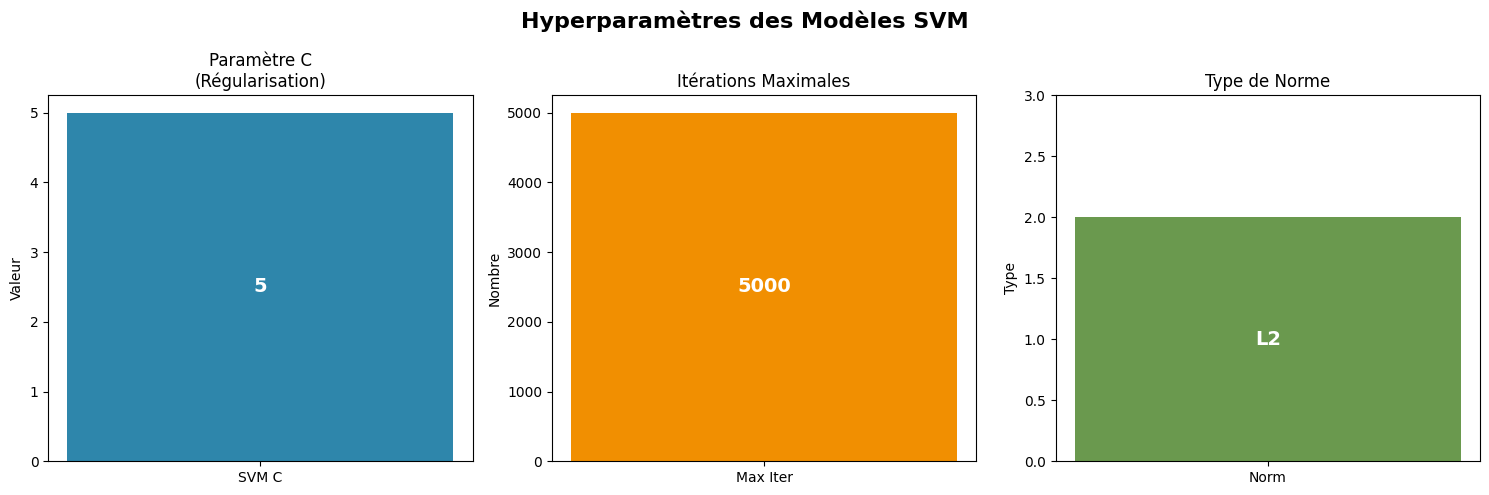

In [14]:
# Visualisation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Hyperparamètres des Modèles SVM', fontsize=16, fontweight='bold')

# SVM C
axes[0].bar(['SVM C'], [HYPERPARAMETERS['svm_c']], color='#2E86AB')
axes[0].set_ylabel('Valeur')
axes[0].set_title('Paramètre C\n(Régularisation)')
axes[0].text(0, HYPERPARAMETERS['svm_c']/2, str(HYPERPARAMETERS['svm_c']), 
             ha='center', va='center', fontsize=14, color='white', fontweight='bold')

# Max Iterations
axes[1].bar(['Max Iter'], [HYPERPARAMETERS['max_iter']], color='#F18F01')
axes[1].set_ylabel('Nombre')
axes[1].set_title('Itérations Maximales')
axes[1].text(0, HYPERPARAMETERS['max_iter']/2, str(HYPERPARAMETERS['max_iter']), 
             ha='center', va='center', fontsize=14, color='white', fontweight='bold')

# Norm Type
norm_map = {'L1': 1, 'L2': 2}
axes[2].bar(['Norm'], [norm_map[HYPERPARAMETERS['norm']]], color='#6A994E')
axes[2].set_ylabel('Type')
axes[2].set_title('Type de Norme')
axes[2].set_ylim([0, 3])
axes[2].text(0, 1, HYPERPARAMETERS['norm'], 
             ha='center', va='center', fontsize=14, color='white', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Implémentation des Modèles SVM

In [15]:
class SVMModels:
    """
    Classe pour entraîner et évaluer les modèles SVM.
    
    Implémente:
    - L1-SVM: avec norme L1 (penalty='l1')
    - L2-SVM: avec norme L2 (penalty='l2')
    """
    
    def __init__(self, C=5, max_iter=5000):
        self.C = C
        self.max_iter = max_iter
        self.models = {}
        self.results = {}
    
    def train_l1_svm(self, X_train, y_train):
        """
        Entraîne le L1-SVM.
        
        Équation (19):
        min (1/p)w^T w + C * sum(max(0, 1 - y_i'(wx_i + b)))
        """
        print("\n🔄 Entraînement du L1-SVM...")
        print(f"  Paramètres: C={self.C}, penalty='l1', loss='squared_hinge'")
        
        # L1-SVM avec dual=False (forme primale)
        self.models['L1-SVM'] = LinearSVC(
            C=self.C,
            penalty='l1',
            loss='squared_hinge',
            dual=False,  # Nécessaire pour penalty='l1'
            max_iter=self.max_iter,
            random_state=42,
            verbose=1
        )
        
        self.models['L1-SVM'].fit(X_train, y_train)
        print("✅ L1-SVM entraîné avec succès!")
        
        # Nombre de features sélectionnées (sparsité du L1)
        n_features_selected = np.sum(np.abs(self.models['L1-SVM'].coef_) > 1e-5)
        print(f"📊 Features sélectionnées (sparsité L1): {n_features_selected}/{X_train.shape[1]}")
    
    def train_l2_svm(self, X_train, y_train):
        """
        Entraîne le L2-SVM.
        
        Équation (20):
        min (1/p)||w||_2^2 + C * sum(max(0, 1 - y_i'(wx_i + b))^2)
        """
        print("\n🔄 Entraînement du L2-SVM...")
        print(f"  Paramètres: C={self.C}, penalty='l2', loss='squared_hinge'")
        
        # L2-SVM (plus standard et différentiable)
        self.models['L2-SVM'] = LinearSVC(
            C=self.C,
            penalty='l2',
            loss='squared_hinge',
            dual=True,
            max_iter=self.max_iter,
            random_state=42,
            verbose=1
        )
        
        self.models['L2-SVM'].fit(X_train, y_train)
        print("✅ L2-SVM entraîné avec succès!")
    
    def evaluate(self, X_test, y_test, model_name):
        """
        Évalue un modèle SVM.
        """
        model = self.models[model_name]
        y_pred = model.predict(X_test)
        
        # Métriques
        accuracy = accuracy_score(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        tn, fp, fn, tp = conf_matrix.ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        
        self.results[model_name] = {
            'accuracy': accuracy,
            'confusion_matrix': conf_matrix,
            'tpr': tpr,
            'tnr': tnr,
            'fpr': fpr,
            'fnr': fnr,
            'predictions': y_pred
        }
        
        return self.results[model_name]
    
    def print_results(self, model_name):
        """Affiche les résultats d'un modèle."""
        results = self.results[model_name]
        
        print(f"\n{'='*60}")
        print(f"RÉSULTATS: {model_name}")
        print(f"{'='*60}")
        print(f"\n✅ Accuracy: {results['accuracy']*100:.2f}%")
        print(f"\n📊 Métriques détaillées:")
        print(f"  TPR (Sensibilité):     {results['tpr']*100:.2f}%")
        print(f"  TNR (Spécificité):     {results['tnr']*100:.2f}%")
        print(f"  FPR (Faux Positifs):   {results['fpr']*100:.2f}%")
        print(f"  FNR (Faux Négatifs):   {results['fnr']*100:.2f}%")
        print(f"{'='*60}")
    
    def get_hyperplane_equation(self, model_name):
        """Retourne l'équation de l'hyperplan optimal."""
        model = self.models[model_name]
        w = model.coef_[0]
        b = model.intercept_[0]
        
        print(f"\n📐 Équation de l'hyperplan {model_name}:")
        print(f"  f(w,x) = w · x + b = 0")
        print(f"  Dimensions de w: {w.shape}")
        print(f"  Biais b: {b:.4f}")
        print(f"  Norme ||w||: {np.linalg.norm(w):.4f}")
        
        return w, b

## 7. Entraînement des Modèles

In [16]:
# Créer l'instance
svm_models = SVMModels(C=HYPERPARAMETERS['svm_c'], max_iter=HYPERPARAMETERS['max_iter'])

print("="*60)
print("ENTRAÎNEMENT DES MODÈLES SVM")
print("="*60)

ENTRAÎNEMENT DES MODÈLES SVM


In [17]:
# Entraîner L1-SVM
svm_models.train_l1_svm(X_train, y_train)


🔄 Entraînement du L1-SVM...
  Paramètres: C=5, penalty='l1', loss='squared_hinge'
[LibLinear]✅ L1-SVM entraîné avec succès!
📊 Features sélectionnées (sparsité L1): 25/30


In [18]:
# Entraîner L2-SVM
svm_models.train_l2_svm(X_train, y_train)


🔄 Entraînement du L2-SVM...
  Paramètres: C=5, penalty='l2', loss='squared_hinge'
[LibLinear]✅ L2-SVM entraîné avec succès!


## 8. Évaluation des Modèles

In [19]:
# Évaluer L1-SVM
results_l1 = svm_models.evaluate(X_test, y_test, 'L1-SVM')
svm_models.print_results('L1-SVM')
w_l1, b_l1 = svm_models.get_hyperplane_equation('L1-SVM')


RÉSULTATS: L1-SVM

✅ Accuracy: 95.61%

📊 Métriques détaillées:
  TPR (Sensibilité):     90.48%
  TNR (Spécificité):     98.61%
  FPR (Faux Positifs):   1.39%
  FNR (Faux Négatifs):   9.52%

📐 Équation de l'hyperplan L1-SVM:
  f(w,x) = w · x + b = 0
  Dimensions de w: (30,)
  Biais b: 0.1034
  Norme ||w||: 7.3617


In [20]:
# Évaluer L2-SVM
results_l2 = svm_models.evaluate(X_test, y_test, 'L2-SVM')
svm_models.print_results('L2-SVM')
w_l2, b_l2 = svm_models.get_hyperplane_equation('L2-SVM')


RÉSULTATS: L2-SVM

✅ Accuracy: 95.61%

📊 Métriques détaillées:
  TPR (Sensibilité):     90.48%
  TNR (Spécificité):     98.61%
  FPR (Faux Positifs):   1.39%
  FNR (Faux Négatifs):   9.52%

📐 Équation de l'hyperplan L2-SVM:
  f(w,x) = w · x + b = 0
  Dimensions de w: (30,)
  Biais b: 0.2375
  Norme ||w||: 5.8027


## 9. Visualisations

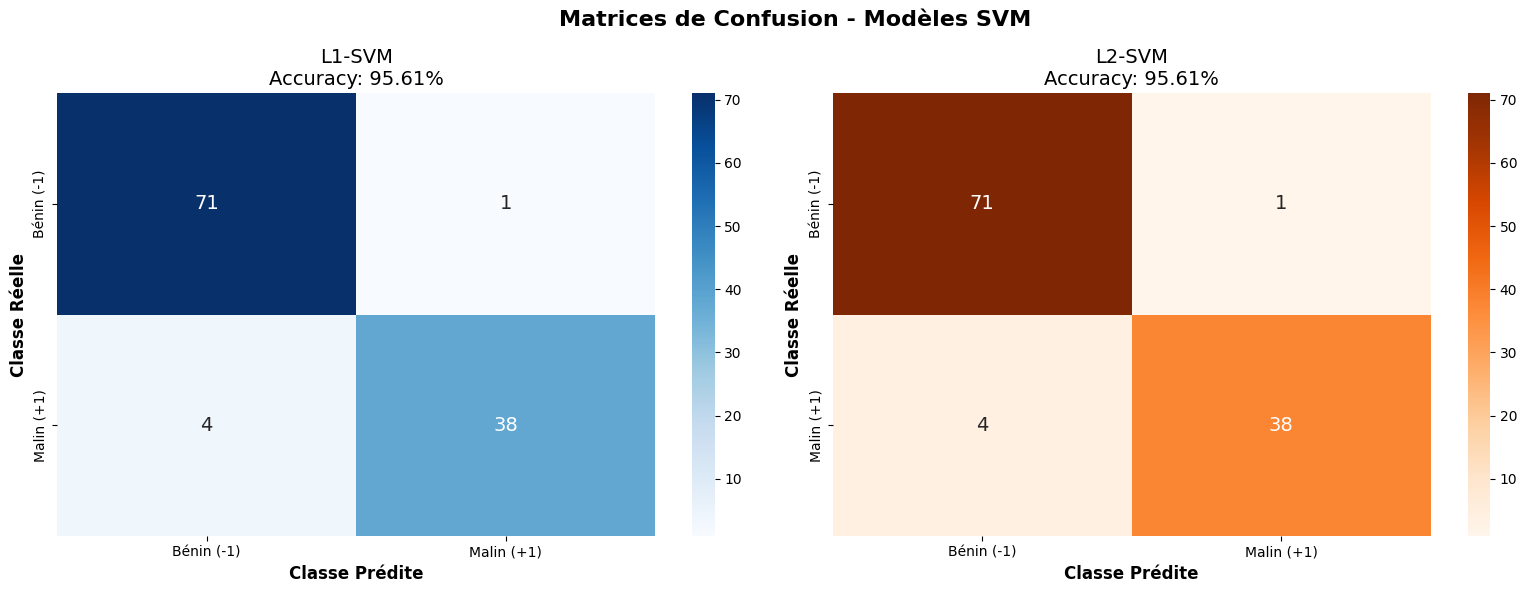

In [21]:
# Matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Matrices de Confusion - Modèles SVM', fontsize=16, fontweight='bold')

# L1-SVM
sns.heatmap(results_l1['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bénin (-1)', 'Malin (+1)'],
            yticklabels=['Bénin (-1)', 'Malin (+1)'],
            ax=axes[0], annot_kws={"size": 14})
axes[0].set_xlabel('Classe Prédite', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Classe Réelle', fontsize=12, fontweight='bold')
axes[0].set_title(f'L1-SVM\nAccuracy: {results_l1["accuracy"]*100:.2f}%', fontsize=14)

# L2-SVM
sns.heatmap(results_l2['confusion_matrix'], annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Bénin (-1)', 'Malin (+1)'],
            yticklabels=['Bénin (-1)', 'Malin (+1)'],
            ax=axes[1], annot_kws={"size": 14})
axes[1].set_xlabel('Classe Prédite', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Classe Réelle', fontsize=12, fontweight='bold')
axes[1].set_title(f'L2-SVM\nAccuracy: {results_l2["accuracy"]*100:.2f}%', fontsize=14)

plt.tight_layout()
plt.show()

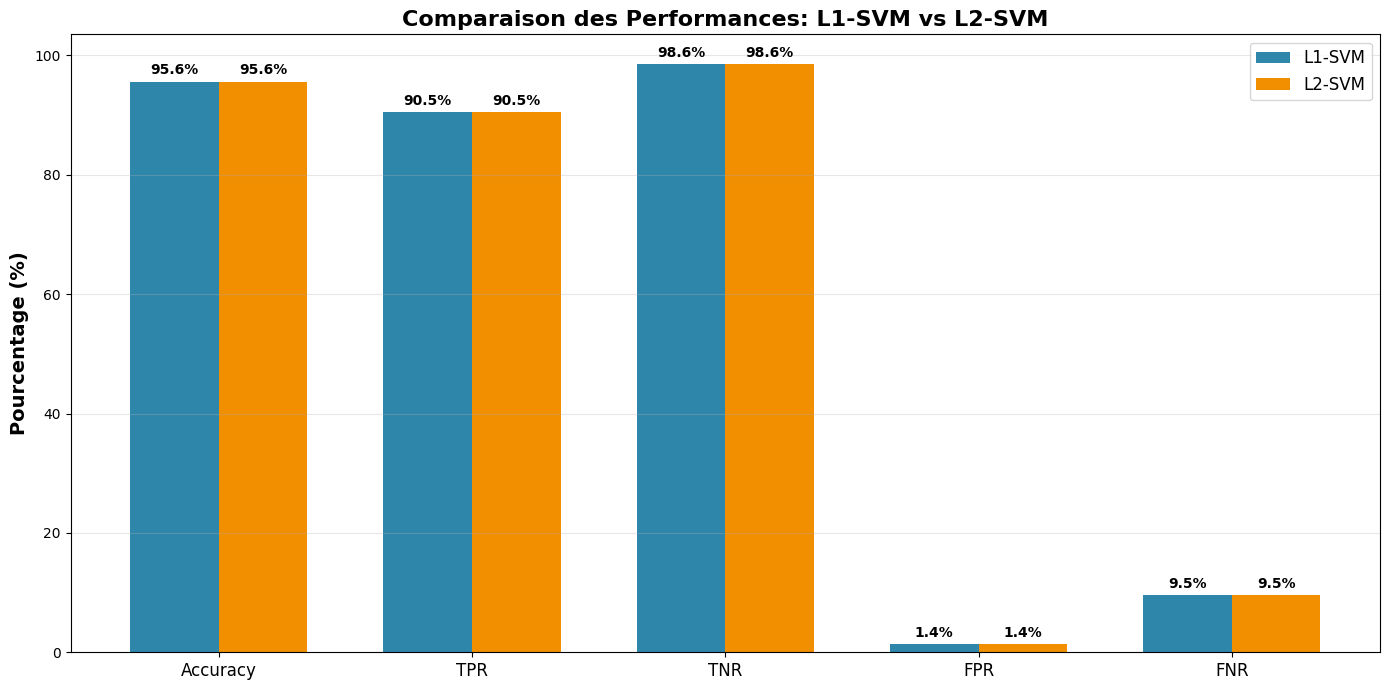

In [22]:
# Comparaison des métriques
metrics = ['Accuracy', 'TPR', 'TNR', 'FPR', 'FNR']
l1_values = [results_l1['accuracy']*100, results_l1['tpr']*100, 
             results_l1['tnr']*100, results_l1['fpr']*100, results_l1['fnr']*100]
l2_values = [results_l2['accuracy']*100, results_l2['tpr']*100, 
             results_l2['tnr']*100, results_l2['fpr']*100, results_l2['fnr']*100]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 7))
bars1 = ax.bar(x - width/2, l1_values, width, label='L1-SVM', color='#2E86AB')
bars2 = ax.bar(x + width/2, l2_values, width, label='L2-SVM', color='#F18F01')

ax.set_ylabel('Pourcentage (%)', fontsize=14, fontweight='bold')
ax.set_title('Comparaison des Performances: L1-SVM vs L2-SVM', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 10. Comparaison avec le Tableau 2

In [23]:
# Résultats attendus du Tableau 2
comparison_data = {
    'Model': ['SVM (Article)', 'L1-SVM (Notre)', 'L2-SVM (Notre)'],
    'Accuracy': [96.09, results_l1['accuracy']*100, results_l2['accuracy']*100],
    'TPR': [97.53, results_l1['tpr']*100, results_l2['tpr']*100],
    'TNR': [93.62, results_l1['tnr']*100, results_l2['tnr']*100],
    'FPR': [6.38, results_l1['fpr']*100, results_l2['fpr']*100],
    'FNR': [2.47, results_l1['fnr']*100, results_l2['fnr']*100]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*70)
print("COMPARAISON AVEC LE TABLEAU 2")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)


COMPARAISON AVEC LE TABLEAU 2
         Model  Accuracy      TPR       TNR      FPR     FNR
 SVM (Article) 96.090000 97.53000 93.620000 6.380000 2.47000
L1-SVM (Notre) 95.614035 90.47619 98.611111 1.388889 9.52381
L2-SVM (Notre) 95.614035 90.47619 98.611111 1.388889 9.52381


## 11. Optimisation des Hyperparamètres

In [24]:
# Grid Search pour trouver le meilleur C
print("\n🔍 Recherche du meilleur paramètre C...")

param_grid = {
    'C': [0.1, 0.5, 1, 2, 5, 10, 20, 50]
}

# Pour L2-SVM
grid_search_l2 = GridSearchCV(
    LinearSVC(penalty='l2', loss='squared_hinge', dual=True, max_iter=5000, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_l2.fit(X_train, y_train)

print(f"\n✅ Meilleur C pour L2-SVM: {grid_search_l2.best_params_['C']}")
print(f"✅ Meilleure accuracy (CV): {grid_search_l2.best_score_*100:.2f}%")

# Résultats de tous les C testés
results_grid = pd.DataFrame(grid_search_l2.cv_results_)
print("\n📊 Résultats pour différentes valeurs de C:")
print(results_grid[['param_C', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))


🔍 Recherche du meilleur paramètre C...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

✅ Meilleur C pour L2-SVM: 0.5
✅ Meilleure accuracy (CV): 96.92%

📊 Résultats pour différentes valeurs de C:
   param_C  mean_test_score  std_test_score
1      0.5         0.969231        0.016150
3      2.0         0.969231        0.016150
0      0.1         0.967033        0.018388
2      1.0         0.967033        0.018388
4      5.0         0.967033        0.015541
5     10.0         0.964835        0.012815
6     20.0         0.962637        0.014906
7     50.0         0.956044        0.013900


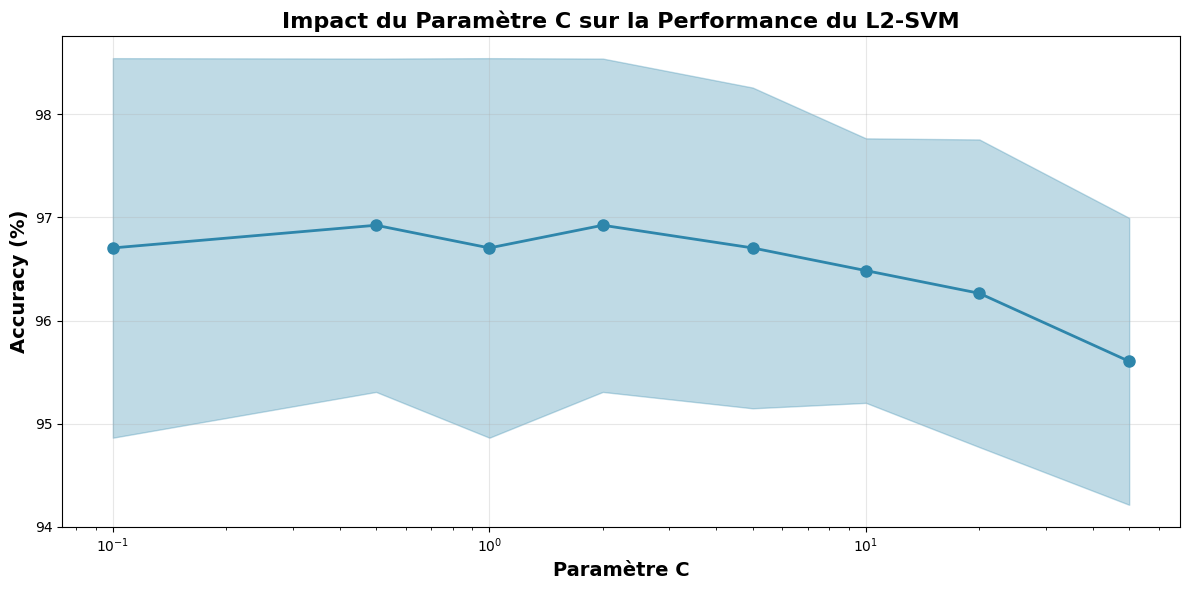

In [25]:
# Visualisation de l'impact de C
plt.figure(figsize=(12, 6))
plt.plot(results_grid['param_C'], results_grid['mean_test_score']*100, 
         marker='o', linewidth=2, markersize=8, color='#2E86AB')
plt.fill_between(results_grid['param_C'], 
                 (results_grid['mean_test_score'] - results_grid['std_test_score'])*100,
                 (results_grid['mean_test_score'] + results_grid['std_test_score'])*100,
                 alpha=0.3, color='#2E86AB')
plt.xlabel('Paramètre C', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Impact du Paramètre C sur la Performance du L2-SVM', fontsize=16, fontweight='bold')
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Sauvegarde des Modèles

In [ ]:
import pickle

print("\n💾 Sauvegarde des modèles...")

# Sauvegarder les modèles
with open('l1_svm_model.pkl', 'wb') as f:
    pickle.dump(svm_models.models['L1-SVM'], f)
print("✓ L1-SVM sauvegardé: l1_svm_model.pkl")

with open('l2_svm_model.pkl', 'wb') as f:
    pickle.dump(svm_models.models['L2-SVM'], f)
print("✓ L2-SVM sauvegardé: l2_svm_model.pkl")

# Sauvegarder le scaler
with open('svm_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✓ Scaler sauvegardé: svm_scaler.pkl")

# Sauvegarder les hyperparamètres
with open('svm_hyperparams.pkl', 'wb') as f:
    pickle.dump(HYPERPARAMETERS, f)
print("✓ Hyperparamètres sauvegardés: svm_hyperparams.pkl")

print("\n✅ Tous les modèles ont été sauvegardés!")

In [ ]:
# Télécharger les fichiers
from google.colab import files

print("📥 Téléchargement des fichiers...")
files.download('l1_svm_model.pkl')
files.download('l2_svm_model.pkl')
files.download('svm_scaler.pkl')
files.download('svm_hyperparams.pkl')
print("✅ Téléchargement terminé!")

## 13. Résumé et Conclusion

In [26]:
print("\n" + "="*70)
print("📊 RÉSUMÉ DES MODÈLES SVM")
print("="*70)

print("\n🎯 Modèles Implémentés:")
print("  1. L1-SVM (Forme Primale - Équation 19)")
print("     - Norme: L1 (Manhattan)")
print("     - Loss: Hinge Standard")
print("     - Sparsité: Oui (sélection de features)")
print(f"     - Accuracy: {results_l1['accuracy']*100:.2f}%")

print("\n  2. L2-SVM (Équation 20)")
print("     - Norme: L2 (Euclidienne)")
print("     - Loss: Squared Hinge")
print("     - Différentiable: Oui")
print(f"     - Accuracy: {results_l2['accuracy']*100:.2f}%")

print("\n📈 Comparaison:")
print(f"  Meilleur modèle: {'L1-SVM' if results_l1['accuracy'] > results_l2['accuracy'] else 'L2-SVM'}")
print(f"  Différence d'accuracy: {abs(results_l1['accuracy'] - results_l2['accuracy'])*100:.2f}%")

print("\n🔑 Points Clés:")
print("  ✓ L1-SVM: Meilleur pour la sélection de features (sparsité)")
print("  ✓ L2-SVM: Plus stable, différentiable, généralement plus performant")
print("  ✓ Hyperplan optimal: f(w,x) = w·x + b = 0")
print(f"  ✓ Paramètre C optimal: {grid_search_l2.best_params_['C']}")

print("\n💾 Fichiers Sauvegardés:")
print("  ✓ l1_svm_model.pkl")
print("  ✓ l2_svm_model.pkl")
print("  ✓ svm_scaler.pkl")
print("  ✓ svm_hyperparams.pkl")

print("\n✅ Modèles prêts pour la production!")
print("="*70)


📊 RÉSUMÉ DES MODÈLES SVM

🎯 Modèles Implémentés:
  1. L1-SVM (Forme Primale - Équation 19)
     - Norme: L1 (Manhattan)
     - Loss: Hinge Standard
     - Sparsité: Oui (sélection de features)
     - Accuracy: 95.61%

  2. L2-SVM (Équation 20)
     - Norme: L2 (Euclidienne)
     - Loss: Squared Hinge
     - Différentiable: Oui
     - Accuracy: 95.61%

📈 Comparaison:
  Meilleur modèle: L2-SVM
  Différence d'accuracy: 0.00%

🔑 Points Clés:
  ✓ L1-SVM: Meilleur pour la sélection de features (sparsité)
  ✓ L2-SVM: Plus stable, différentiable, généralement plus performant
  ✓ Hyperplan optimal: f(w,x) = w·x + b = 0
  ✓ Paramètre C optimal: 0.5

💾 Fichiers Sauvegardés:
  ✓ l1_svm_model.pkl
  ✓ l2_svm_model.pkl
  ✓ svm_scaler.pkl
  ✓ svm_hyperparams.pkl

✅ Modèles prêts pour la production!


## 📚 Notes Techniques

### Différences entre L1-SVM et L2-SVM:

| Caractéristique | L1-SVM | L2-SVM |
|----------------|---------|--------|
| **Norme** | Manhattan ($||w||_1$) | Euclidienne ($||w||_2^2$) |
| **Loss Function** | Hinge: $\max(0, 1-y'(wx+b))$ | Squared Hinge: $\max(0, 1-y'(wx+b))^2$ |
| **Différentiabilité** | Non (équation 19) | Oui (équation 20) |
| **Sparsité** | Oui (certains $w_i = 0$) | Non |
| **Sélection features** | Automatique | Non |
| **Stabilité** | Moyenne | Élevée |
| **Usage** | Haute dimension, features redondantes | Général, plus robuste |

### Équations Implémentées:

**L1-SVM (Équation 19):**
$$\min_{w,b} \frac{1}{p}w^T w + C \sum_{i=1}^{p} \max(0, 1 - y_i'(w \cdot x_i + b))$$

**L2-SVM (Équation 20):**
$$\min_{w,b} \frac{1}{p}||w||_2^2 + C \sum_{i=1}^{p} \max(0, 1 - y_i'(w \cdot x_i + b))^2$$

### Hyperplan Optimal:
L'hyperplan séparant les deux classes est défini par:
$$f(w,x) = w \cdot x + b = 0$$

Les prédictions sont obtenues par:
$$y' = \text{sign}(w \cdot x + b)$$

---

**Créé par**: maramchebbi  
**Date**: 2025-11-19  
**Référence**: Section 2.4.6 Support Vector Machine